In [1]:
using ITensors, TimeEvoMPS

┌ Info: Precompiling ITensors [9136182c-28ba-11e9-034c-db9fb085ebd5]
└ @ Base loading.jl:1278
┌ Info: Precompiling TimeEvoMPS [1bec0e0a-d6ff-11e9-2fd9-7928ca571592]
└ @ Base loading.jl:1278


variabelen definiëren

In [323]:
N=5
h_0=1
h=2
J=1;

$$H=-J \sum_{i} \sigma_{i}^{z} \sigma_{i+1}^{z}-J h \sum_{i} \sigma_{i}^{x}$$

Grondtoestand berekenen met $h_0$

In [337]:
sites = siteinds("S=1/2",N)

ampo = AutoMPO()
for j=1:N-1
    add!(ampo,-J,"Sz",j,"Sz",j+1)
    add!(ampo,-h_0*J,"Sx",j)
end
add!(ampo,-h_0*J,"Sx",N)
H= MPO(ampo,sites)

sweeps = Sweeps(5) # number of sweeps is 5
maxdim!(sweeps,10,20,100,100,200) # gradually increase states kept
cutoff!(sweeps,1E-10) # desired truncation error

psi0 = randomMPS(sites,2)

energy,psi = dmrg(H,psi0,sweeps)

return

After sweep 1 energy=-2.625964592298 maxlinkdim=4 time=0.008
After sweep 2 energy=-2.625969324432 maxlinkdim=4 time=0.004
After sweep 3 energy=-2.625969324434 maxlinkdim=4 time=0.004
After sweep 4 energy=-2.625969324434 maxlinkdim=4 time=0.004
After sweep 5 energy=-2.625969324434 maxlinkdim=4 time=0.004


In [319]:
# N=5
# sites= siteinds("S=1/2",N)
# psi = randomMPS(sites,fill("↑",N));

Tijdsevolutie met h

In [338]:
ampo = AutoMPO()
for j=1:N-1
    add!(ampo,-J,"Sz",j,"Sz",j+1)
    add!(ampo,-h*J,"Sx",j)
end
add!(ampo,-h*J,"Sx",N)
H= MPO(ampo,sites);


In [328]:
dt=0.05
tf=10
maxdim=20
cb = LocalMeasurementCallback(["Sz","Sx","Sy"], sites,0.2)
# cb = LocalMeasurementCallback(["Sx"], sites,0.2)
tdvp!(psi,H,dt,tf,maxdim=maxdim, callback=cb)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\alexa\.julia\packages\ProgressMeter\poEzd\src\ProgressMeter.jl:463
Evolving state... 100%|█████████████████████████████████| Time: 0:00:10
  t:             10.0
  dt step time:  0.046
  Max bond-dim:  4


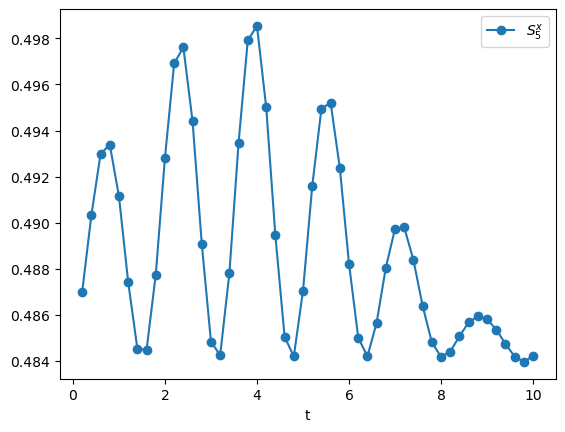

PyObject Text(0.5, 24.0, 't')

In [339]:
using PyPlot
ts = measurement_ts(cb)
for o in ["x"]
    S0= getindex.(measurements(cb)["S$o"],1)
    plot(ts,S0,"-o",label="\$S^$(o)_5\$")
end
legend()
xlabel("t")

$$\theta_{k} =\arg \left(h-e^{i k}\right)
$$

In [330]:
function theta(k,h)
    angle(h-exp(im*k))
end

theta (generic function with 2 methods)

$$
\epsilon_{k}=2 J \sqrt{1+h^{2}-2 h \cos (k)}
$$

In [331]:
function eps(k)
    2*J*sqrt(1+h^2-2*h*cos(k))
end

eps (generic function with 1 method)

$$
\left\langle\sigma_{i}^{x}\right\rangle=1-\frac{1}{N} \sum_{k}\left(1-\cos \left(\Delta \theta_{k}\right) \cos \theta_{k}-\cos \left(2 \epsilon_{k} t\right) \sin \Delta \theta_{k} \sin \theta_{k}\right)
$$

In [351]:
function term(th, th_0, Delta_th, eps_k,t)
    1-cos(Delta_th)*cos(th)-cos(2*eps_k*t)*sin(Delta_th)*sin(th)
end

term (generic function with 2 methods)

In [354]:
function s_x(t)
    S_x=zeros(0)
    k=-pi.+ (2*pi/N)*collect(0:1:N-1)    
    for j in 1:length(t)
        sum=0.0        
        for i in 1:N
            th=theta(k[i],h)
            th_0=theta(k[i],h_0)
            Delta_th=th-th_0
            eps_k=eps(k[i])
            sum+=term(th, th_0, Delta_th, eps_k,t[j])
        end
        append!(S_x,1-sum/N)
    end
    S_x
end

s_x (generic function with 4 methods)

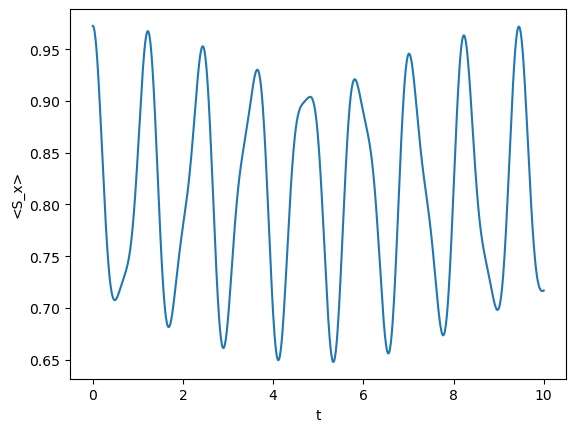

PyObject Text(24.000000000000007, 0.5, '<S_x>')

In [355]:
t=collect(0:0.01:tf)
plot(t,s_x(t))
xlabel("t")
ylabel("<S_x>")